# Algorithmic trading with Keras (using LSTM)

We use a Long Short Time Memory recurrent neural network to develop a good trading strategy for the S&P 500 index: the first trading day of each month we want our model to tell us if we are going to stay in the market for the current month or not.

We verify that, in a period of 4 years which comprehends the 2008 crisis, this LSTM-trading-strategy is far better than the buy and hold strategy (stay always in the market) and the moving average strategy (buy when the current price is greater or equal to the moving average of past 12 months and sell otherwise). 

We compute the gross and net yield (as it is by the Italian law: 26% tax on capital gain and 0.10% fee to the broker at each transaction): our model performed roughly a 10% net annual yield (which is not bad, considering the 2008 crisis)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
from scipy.optimize import brute

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Part 1: Get the data 

We use Yahoo Finance to get the data of the S&P 500 index. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For this reason, we fix the conventin that *start_date* will always be the first day of a month and *end_date* will always be the last day of a month.

For a reason which will be clarified by the following code, our analysis will start from 24 months after the month of *start_date* and end the month before the month of *end_date*

In [2]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011,3,31)

In [3]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2011-03-25  1319.180054  1310.150024  1311.800049  1313.800049  4223740000
2011-03-28  1319.739990  1310.189941  1315.449951  1310.189941  3215170000
2011-03-29  1319.449951  1305.260010  1309.369995  1319.439941  3482580000
2011-03-30  1331.739990  1321.890015  1321.890015  1328.260010  3809570000
2011-03-31  1329.770020  1325.030029  1327.439941  1325.829956  3566270000


In order to develop our trading strategy, we need to obtain a dataframe with the monthly means and the first trading day of the month price. First we obtain the monthly means

In [4]:
dfm=df.resample("M").mean()

dfm=dfm[:-1] # As we said, we do not consider the month of end_date

print(dfm.head())
print(dfm.tail())

                  High         Low        Open       Close        Volume
Date                                                                    
1973-01-31  119.544761  117.500953  118.518572  118.421905  1.875000e+07
1973-02-28  115.360001  113.265263  114.395264  114.164211  1.674684e+07
1973-03-31  113.389547  111.349545  112.421363  112.415454  1.560909e+07
1973-04-30  111.285500  109.283501  110.496000  110.274000  1.389950e+07
1973-05-31  108.311818  105.961363  107.278637  107.219546  1.533000e+07
                   High          Low         Open        Close        Volume
Date                                                                        
2010-10-31  1176.353812  1163.752848  1169.972842  1171.583810  4.263632e+09
2010-11-30  1203.925717  1190.292852  1198.232840  1198.888561  4.150051e+09
2010-12-31  1244.202271  1236.147267  1238.899092  1241.525452  3.681115e+09
2011-01-31  1286.889008  1275.542999  1281.354504  1282.618500  4.608247e+09
2011-02-28  1324.536319  13

Then we obtain the list of the first trading day for each month

In [5]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

Now for each month we have the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature *rapp* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be used because it gives the variation of the portfolio for the current month

In [6]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [7]:
print(dfm.head())
print(dfm.tail())

                  High         Low        Open       Close        Volume  \
Date                                                                       
1973-01-31  119.544761  117.500953  118.518572  118.421905  1.875000e+07   
1973-02-28  115.360001  113.265263  114.395264  114.164211  1.674684e+07   
1973-03-31  113.389547  111.349545  112.421363  112.415454  1.560909e+07   
1973-04-30  111.285500  109.283501  110.496000  110.274000  1.389950e+07   
1973-05-31  108.311818  105.961363  107.278637  107.219546  1.533000e+07   

                fd_cm      fd_nm  fd_cm_open  fd_nm_open      rapp  
Date                                                                
1973-01-31 1973-01-02 1973-02-01  118.059998  116.029999  0.982805  
1973-02-28 1973-02-01 1973-03-01  116.029999  111.680000  0.962510  
1973-03-31 1973-03-01 1973-04-02  111.680000  111.519997  0.998567  
1973-04-30 1973-04-02 1973-05-01  111.519997  106.970001  0.959200  
1973-05-31 1973-05-01 1973-06-01  106.970001  104.949

Now we add the columns corresponding to the moving averages at 1 and 2 years

In [8]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

Note that in this way each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)

In [9]:
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean())

Date
1980-03-31    105.29345
Freq: M, Name: mv_avg_12, dtype: float64
Date
1979-03-31     99.873636
1979-04-30    102.056000
1979-05-31     99.835000
1979-06-30    101.545238
1979-07-31    102.668571
1979-08-31    107.116521
1979-09-30    108.583684
1979-10-31    104.745652
1979-11-30    103.467143
1979-12-31    107.687000
1980-01-31    110.585454
1980-02-29    115.357501
Freq: M, Name: Open, dtype: float64
105.293450059


We remove the first 24 months, since they do not have the 2-year moving average

In [10]:
dfm=dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print dfm.index

DatetimeIndex(['1975-01-31', '1975-02-28', '1975-03-31', '1975-04-30',
               '1975-05-31', '1975-06-30', '1975-07-31', '1975-08-31',
               '1975-09-30', '1975-10-31',
               ...
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31',
               '2011-01-31', '2011-02-28'],
              dtype='datetime64[ns]', name=u'Date', length=434, freq='M')


Finally, we can divide *dfm* in train and test set

In [11]:
mtest=72
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

In [12]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We just need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction

In [13]:
tax_cg=0.26
comm_bk=0.001

In [14]:
# This function will be used in the function yield_net

# Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
# and their number. 
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

Again, the vector v selects which months we are going to stay in the market

In [15]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

## Part 3: Definition of LSTM model

We want to use a LSTM neural network to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market

In [16]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print(X_dfw.shape)
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

y_dfw=np.array(dg[8][window:])

(430, 5, 8)
          0         1         2         3         4         5         6  \
0  0.000000  0.000000  0.000000  0.000000  0.000893  0.000000  0.003542   
1  0.005053  0.005110  0.005180  0.005134  0.001252  0.005639  0.002118   
2  0.007630  0.007737  0.007810  0.007680  0.001305  0.008760  0.001307   
3  0.008219  0.008411  0.008387  0.008288  0.001010  0.009958  0.000482   

          7         0         1    ...            6         7         0  \
0  0.008064  0.005053  0.005110    ...     0.000482  0.004628  0.011912   
1  0.006613  0.007630  0.007737    ...     0.000000  0.003815  0.013394   
2  0.005529  0.008219  0.008411    ...     0.000007  0.003270  0.013602   
3  0.004628  0.011912  0.012082    ...     0.000149  0.002876  0.008884   

          1         2         3         4         5         6         7  
0  0.012082  0.012053  0.011950  0.001183  0.012626  0.000000  0.003815  
1  0.013716  0.013614  0.013519  0.001115  0.015347  0.000007  0.003270  
2  0.013922  0

In [18]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [19]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

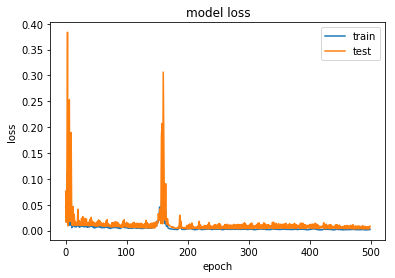

In [20]:
model=model_lstm(window+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
y_pr=model.predict(X_trainw)

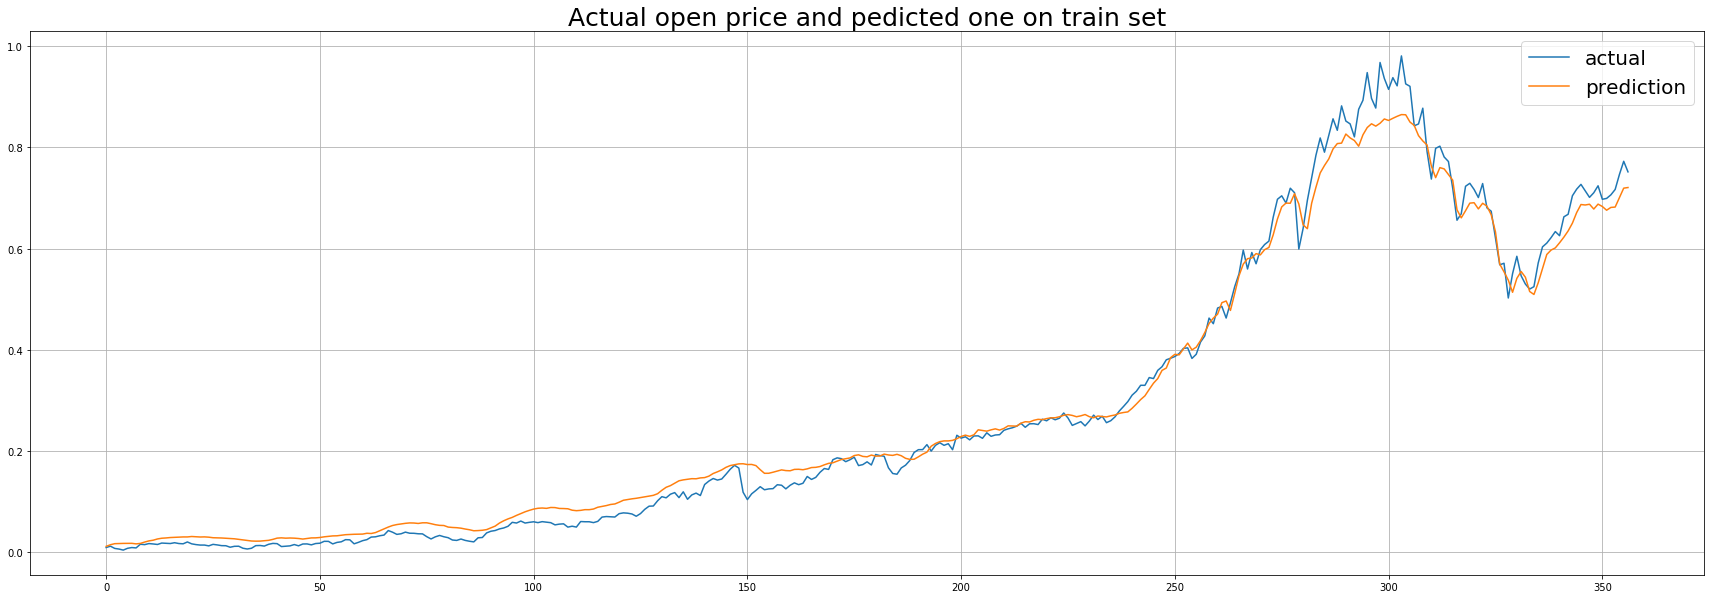

In [22]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [23]:
y_pred=model.predict(X_testw)

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector v indicates the "in months" (as 1s) and "out months" (as 0s)**

In [24]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

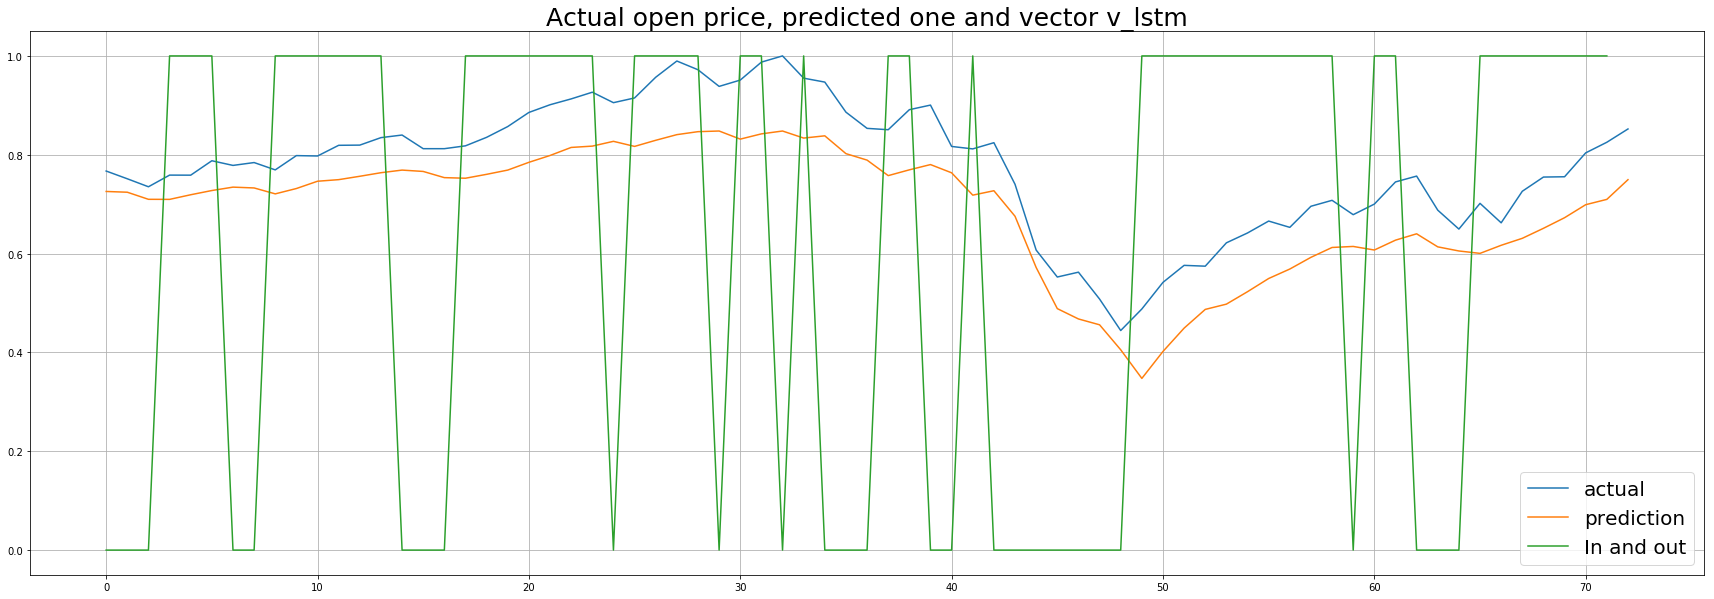

In [25]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our model: it is quite good at predicting the sign of the first derivative of the index, but this is exactly what we need for our trading strategy!** 

## Part 4: Compare the LSTM method with other methods

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [26]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [27]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

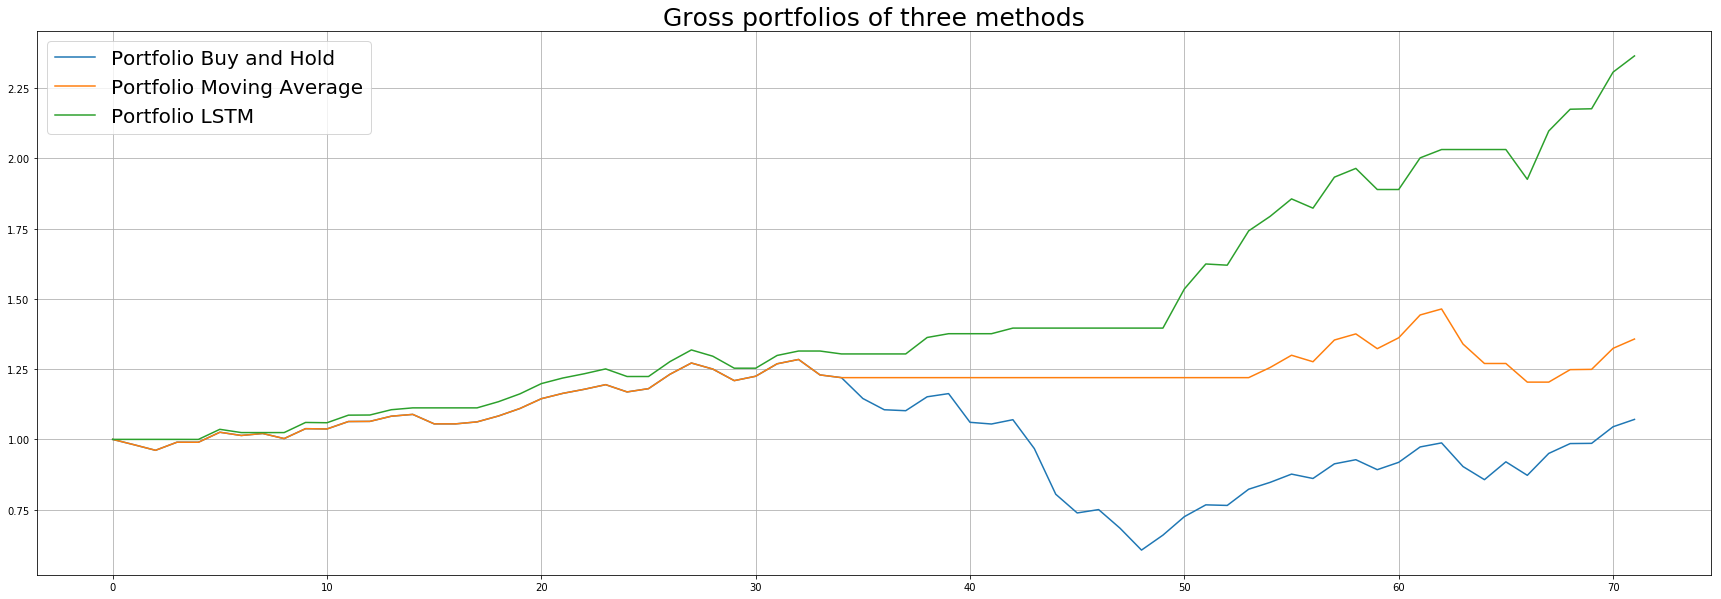

In [28]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [30]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results)

Test period of 6.00 years, from 2005-03-01 to 2011-03-01 

           Method Total gross yield Annual gross yield Total net yield  \
0    Buy and hold           10.39 %             1.66 %          7.47 %   
1  Moving average           39.86 %             5.75 %         26.14 %   
2            LSTM          143.67 %             16.0 %         91.38 %   

  Annual net yield  
0           1.21 %  
1           3.95 %  
2          11.43 %  
